In [2]:
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
import seaborn as sns
from IPython.display import Image  
from six import StringIO  
import pydot

# Two Applications of Deep Learning in the Physical Layer of Communication Systems

This notebook is based on the aforementioned paper by Emil Björnson and Pontus Giselsson.

### Abstract

Deep learning has proved itself to be a powerful tool to develop data-driven signal processing algorithms
for challenging engineering problems. By learning the key features and characteristics of the input signals,
instead of requiring a human to first identify and model them, learned algorithms can beat many manmade algorithms. In particular, deep neural networks are capable of learning the complicated features in
nature-made signals, such as photos and audio recordings, and use them for classification and decision
making.
The situation is rather different in communication systems, where the information signals are manmade, the propagation channels are relatively easy to model, and we know how to operate close to the
Shannon capacity limits. Does this mean that there is no role for deep learning in the development of
future communication systems?

In [3]:
# Number of QPSK symbols to be transmitted.
N = 10000

In [10]:
def mod(V):
    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    c_seq = mod(np.array([0,1,2,3]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

def toOneHotEncoding(V):
    bits = np.zeros((len(V),4))
    for i in range(0,len(V)):
        if(V[i]==0):
            bits[i,:] = np.array([1,0,0,0])
        elif(V[i]==1):
            bits[i,:] = np.array([0,1,0,0])
        elif(V[i]==2):
            bits[i,:] = np.array([0,0,1,0])
        else:
            bits[i,:] = np.array([0,0,0,1])
    return bits
    
def fromOneHotEncoding(bits):
    v = np.argmax(bits, axis=0)
    return v

def optimumDemod(y):
    d = np.zeros((len(y),))
    for i in range(0,len(y)):
        if(y[i, 0] >= 0 and y[i, 1] >= 0):
            d[i] = 3
        elif(y[i, 0] < 0 and y[i, 1] >= 0):
            d[i] = 1
        elif(y[i, 0] < 0 and y[i, 1] < 0):
            d[i] = 0
        elif(y[i, 0] >= 0 and y[i, 1] < 0):
            d[i] = 2
        else:
            print('Error....')
    return d

def detection(clf, XY, isMLP):
    if(isMLP==False):
        ZZ = clf.predict(XY)
        Z = np.zeros((len(ZZ),))
        for i in range(0,len(Z)):
            Z[i] = fromOneHotEncoding(ZZ[i,:])
    else:
        Z = optimumDemod(XY)
    return Z

def plotDecisionBoundaries(Y, clf, v_train, SER, titleStr):
    # Step size in the mesh.
    h = .02 

    plt.figure(figsize=(15, 5))
    # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = Y[:, 0].min() - 1, Y[:, 0].max() + 1
    y_min, y_max = Y[:, 1].min() - 1, Y[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    XY = np.c_[xx.ravel(), yy.ravel()]
    
    for i in range(0,2):
        ax = plt.subplot(1, 2, i + 1)
    
        Z = detection(clf, XY, i)
        # Put the result into a color plot.
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, shading='auto')

        # Plot also the training points.
        plt.scatter(Y[:, 0], Y[:, 1], c=v_train.ravel(), edgecolor='k', s=30)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel('$x_1$', fontsize=14)
        plt.ylabel('$x_2$', fontsize=14)
        plt.title(titleStr[i]+' - SER: '+str(SER[i]))
    
    plt.show()

In [11]:
clf = MLPClassifier(hidden_layer_sizes=(10,4), activation='logistic', random_state=4, max_iter=4000)

# Generate N binary symbols.
V = np.random.randint(0,4,(N,1))
    
# Modulate binary stream into QPSK symbols.
s = mod(V)
    
# Generate noise vector. 
# Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
# Pass symbols through AWGN channel.
y = s + np.sqrt(0.2)*noise
    
# Split array into random train and test subsets.
s_test, s_train, y_test, y_train, v_test, v_train = train_test_split(s, y, V, random_state=0)
    
Y = np.c_[y_train.real,y_train.imag]
    
# Fit models for real and imaginary parts.
clf.fit(Y, toOneHotEncoding(v_train))
    
# Prediction.
detected_mlp = clf.predict(np.c_[y_test.real, y_test.imag])
detected_opt = optimumDemod(np.c_[y_test.real, y_test.imag])
   
# Simulated QPSK BER.
error = 0
for i in range(0, len(v_test)):
    if((v_test[i,0] != fromOneHotEncoding(detected_mlp[i,:]) )==True): 
        error = error + 1
    
ser_simu_mlp = 1.0 * error / len(v_test)

print('MLP SER: ',ser_simu_mlp)

# Simulated QPSK BER.
error = 0
for i in range(0, len(v_test)):
    if((v_test[i,0] != detected_opt[i] )==True): 
        error = error + 1
    
ser_simu_opt = 1.0 * error / len(v_test)
    
print('OPT SER: ',ser_simu_opt)

MLP SER:  0.0252
OPT SER:  0.0236


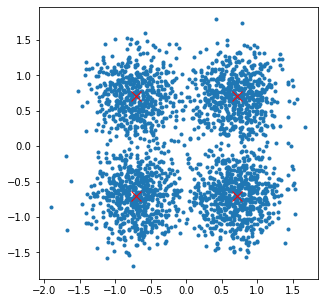

In [12]:
s = mod(np.array([0,1,2,3]))
plt.figure(figsize=(5,5))
plt.plot(Y[:, 0], Y[:, 1],'.')
plt.plot(s.real,s.imag,'rx',markersize=10)
plt.show()

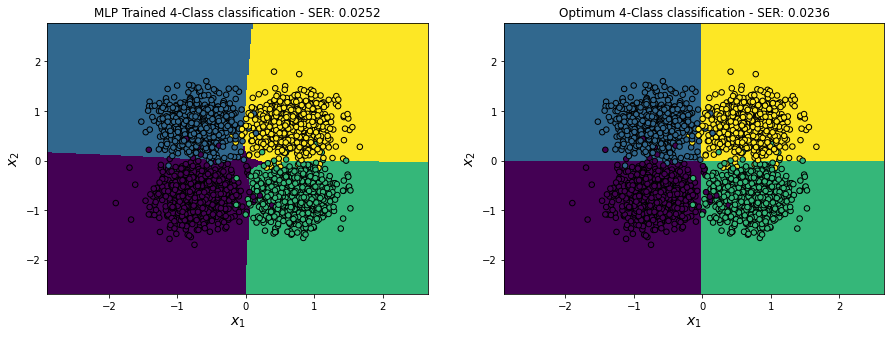

In [13]:
titleStr = ['MLP Trained 4-Class classification', 'Optimum 4-Class classification']
SER = [ser_simu_mlp, ser_simu_opt]
plotDecisionBoundaries(Y, clf, v_train, SER, titleStr)

Several important observations can be made from this example:

1) If there is a known optimal algorithm, a trained neural network cannot outperform it. The detection error probability is, however, almost the same in this example since most received signals appear within the black box where the neural network has a decent behavior.

2) The detection regions in Fig. 2(b) are wrongly shaped since all training examples appeared inside the black box around the signal points. Nevertheless, the long tail of the Gaussian distribution will occasionally give received signals far outside this box. Since this never happened during training, the neural network does not know what to do and can make strange miscategorizations. It has learned to interpolate between training examples but not to extrapolate. This is a general issue; neural networks are good at handling typical inputs but may generalize poorly to atypical inputs.

3) We could have used prior domain knowledge (from digital communications) to preprocess the input signals. In this example, the neural network had to rediscover where the constellation points are, how the noise is distributed, and how to make the right detection. If we would instead compute the Euclidean distance between the received signal and each of the four signal constellation points, we could use that as input to a neural network. This will give more accurate and reliable results since the neural network has fewer characteristics to learn, but it still cannot beat the optimal detection.

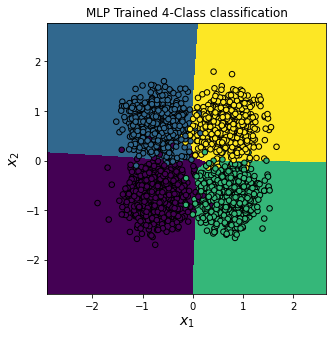

In [17]:
# Step size in the mesh.
h = .02 

plt.figure(figsize=(5, 5))
# Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = Y[:, 0].min() - 1, Y[:, 0].max() + 1
y_min, y_max = Y[:, 1].min() - 1, Y[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

XY = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(XY)

ZZ = np.zeros((len(Z),))
for i in range(0,len(Z)):
    ZZ[i] = fromOneHotEncoding(Z[i,:])

# Put the result into a color plot.
Z = ZZ.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, shading='auto')

# Plot also the training points.
plt.scatter(Y[:, 0], Y[:, 1], c=v_train.ravel(), edgecolor='k', s=30)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title("MLP Trained 4-Class classification")
plt.show()

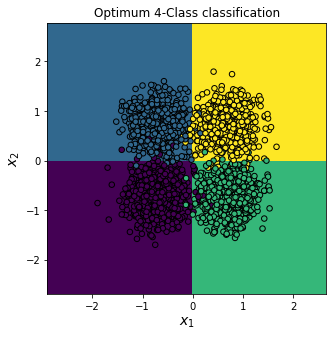

In [16]:
# Step size in the mesh.
h = .02 

plt.figure(figsize=(5, 5))
# Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = Y[:, 0].min() - 1, Y[:, 0].max() + 1
y_min, y_max = Y[:, 1].min() - 1, Y[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

XY = np.c_[xx.ravel(), yy.ravel()]
Z = optimumDemod(XY)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, shading='auto')

# Plot also the training points.
plt.scatter(Y[:, 0], Y[:, 1], c=v_train.ravel(), edgecolor='k', s=30)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title("Optimum 4-Class classification")
plt.show()